**0. Описание задачи**

На основании данных о пользователях и их активности в приложении, необходимо предсказать статус пользователя ( retained или churned)
* ID - идентификатор
* label - статус ползоваиеля
* sessions - число открытий приложения в течение месяца
* drives - количество поездок не менее 1 км за месяц
* total_sessions - всего сессий за время наблюдения
* n_days_after_onboarding - количество дней после регистрации
* total_navigations_fav1 - общее количество переходов с момента регистрации на любимом месте пользователя: 1
* total_navigations_fav2 - общее количество переходов с момента регистрации на любимом месте пользователя: 2
* driven_km_drives - общее количество пройденных километров за месяц
* duration_minutes_drives - общая продолжительность вождения в минутах в течение месяца
* activity_days - количество дней в месяц, когда пользователь открывает приложение
* driving_days - количество дней, когда пользователь совершает поездки (не менее 1 км) в течение месяца
* device - тип устройства, с которого пользователь начинает сеанс

**1. Чение данных**

In [45]:
!pip install ace-tools-open

In [46]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joaofilipemarques/google-advanced-data-analytics-waze-user-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/joaofilipemarques/google-advanced-data-analytics-waze-user-data/versions/1


**2. Визуализация данных и подсчет основных параметров**

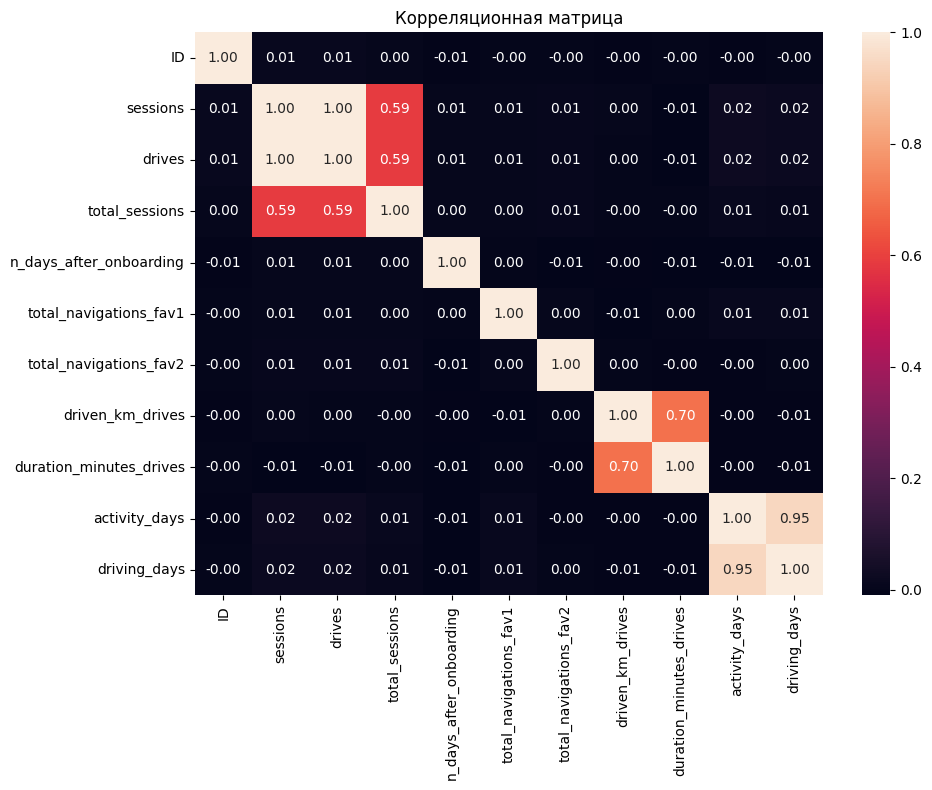

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv("sample_data/waze_dataset.csv")
data_describe = data.describe()
data_cleaned_corr = data.drop(columns=['label', 'device'])
correlation_matrix = data_cleaned_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Корреляционная матрица')
plt.tight_layout()

сильная корелляция:

* driven_k_drives - duration_minutes_drives
* activity_days - driving_days
* drives - sessions
* sessions - total sessions
* total_sessions - drives



**3. Обработка пропущенных значений**

In [48]:
missing_values = data.isnull().sum()
missing_label_count = missing_values['label']
missing_values, missing_label_count

(ID                           0
 label                      700
 sessions                     0
 drives                       0
 total_sessions               0
 n_days_after_onboarding      0
 total_navigations_fav1       0
 total_navigations_fav2       0
 driven_km_drives             0
 duration_minutes_drives      0
 activity_days                0
 driving_days                 0
 device                       0
 dtype: int64,
 700)

в свойстве label всего 700 пропущенных значений, удалим их.

In [49]:
data_cleaned = data.dropna(subset=['label'])

new_shape = data_cleaned.shape
new_shape

(14299, 13)

в новой таблице 14299 столбцов

**4. Обработка категориалных признаков**

<Figure size 1000x800 with 0 Axes>

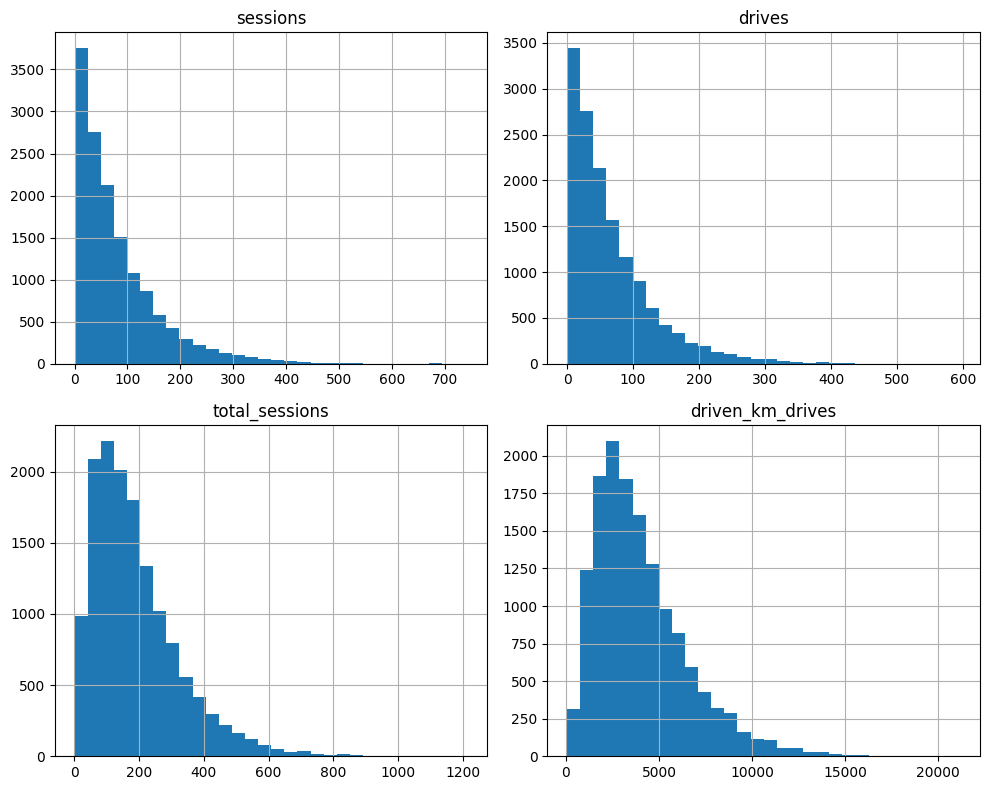

In [50]:
data_encoded = pd.get_dummies(data_cleaned, columns=['device'], drop_first=True)
plt.figure(figsize=(10, 8))
data_encoded[['sessions', 'drives', 'total_sessions', 'driven_km_drives']].hist(bins=30, layout=(2, 2), figsize=(10, 8))
plt.tight_layout()
plt.show()

**5. Нормализация данных**

Перед тем, как исползовать классификатор knn необходимо нормализовать данные,
т.к. knn чувствителен к масштабированию данных

In [51]:
from sklearn.preprocessing import StandardScaler
data_for_scaling = data_encoded.copy()
numeric_features = [
    'sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
    'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
    'duration_minutes_drives', 'activity_days', 'driving_days'
]

scaler = StandardScaler()
data_for_scaling[numeric_features] = scaler.fit_transform(
    data_for_scaling[numeric_features])

**6. Разбиение на обучающую и тестовую выборки**

In [52]:
from sklearn.model_selection import train_test_split

X = data_for_scaling.drop(['ID', 'label'], axis=1)
y = data_for_scaling['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)
split_shapes = (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

**7. Кластеризация с помощю k-means, dbscan, иерархическая кластеризация**

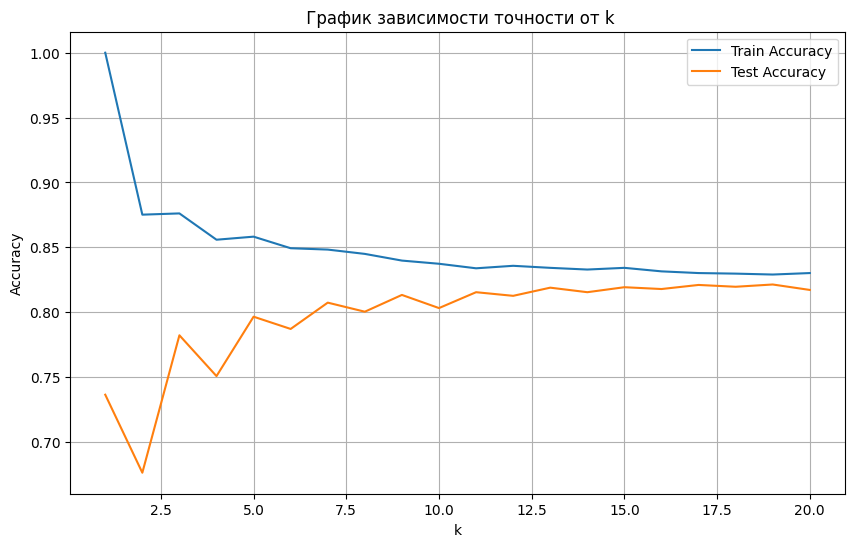

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

k_values = range(1, 21)
train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy')
plt.plot(k_values, test_accuracies, label='Test Accuracy')
plt.title(' График зависимости точности от k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**8. Вычислить ошибки на обучающей и тестовой выборках. Выбрать оптимальное значение гиперпараметра**

In [54]:
import numpy as np
optimal_k = k_values[np.argmax(test_accuracies)]
optimal_accuracy = max(test_accuracies)
optimal_k, optimal_accuracy

(19, 0.8213286713286714)

Оптималное значение k - 19.

Обучение KNN с оптималным занчением k

In [55]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
train_accuracy_optimal = accuracy_score(y_train, knn_optimal.predict(X_train))
test_accuracy_optimal = accuracy_score(y_test, knn_optimal.predict(X_test))

* оптимальная точность тренировочной выборки - 83%
* оптимальная точность тестовой выборки - 82%

**9. Общие выводы**

Общие выводы:При оптимальном значении k модель KNN показывает небольшой уровень ошибки на тестовой выборке - 82%. Оптимальное значение k - 19.

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

# === КЛАСТЕРИЗАЦИЯ ===

# 1. KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")

# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
dbscan_silhouette = silhouette_score(X, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")

# 3. Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X)
agglo_silhouette = silhouette_score(X, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette:.4f}")

# === СРАВНЕНИЕ С ИСТИННЫМИ МЕТКАМИ ===
if 'label' in data_cleaned.columns:
    true_labels = data_cleaned['label']

    kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
    print(f"KMeans ARI: {kmeans_ari:.4f}")

    if dbscan_silhouette is not None:
        dbscan_ari = adjusted_rand_score(true_labels, dbscan_labels)
        print(f"DBSCAN ARI: {dbscan_ari:.4f}")

    agglo_ari = adjusted_rand_score(true_labels, agglo_labels)
    print(f"Agglomerative Clustering ARI: {agglo_ari:.4f}")


KMeans Silhouette Score: 0.2121
DBSCAN Silhouette Score: -0.1176
Agglomerative Clustering Silhouette Score: 0.1400
KMeans ARI: 0.0107
DBSCAN ARI: -0.0005
Agglomerative Clustering ARI: 0.0098


KMeans Silhouette Score: 0.2121


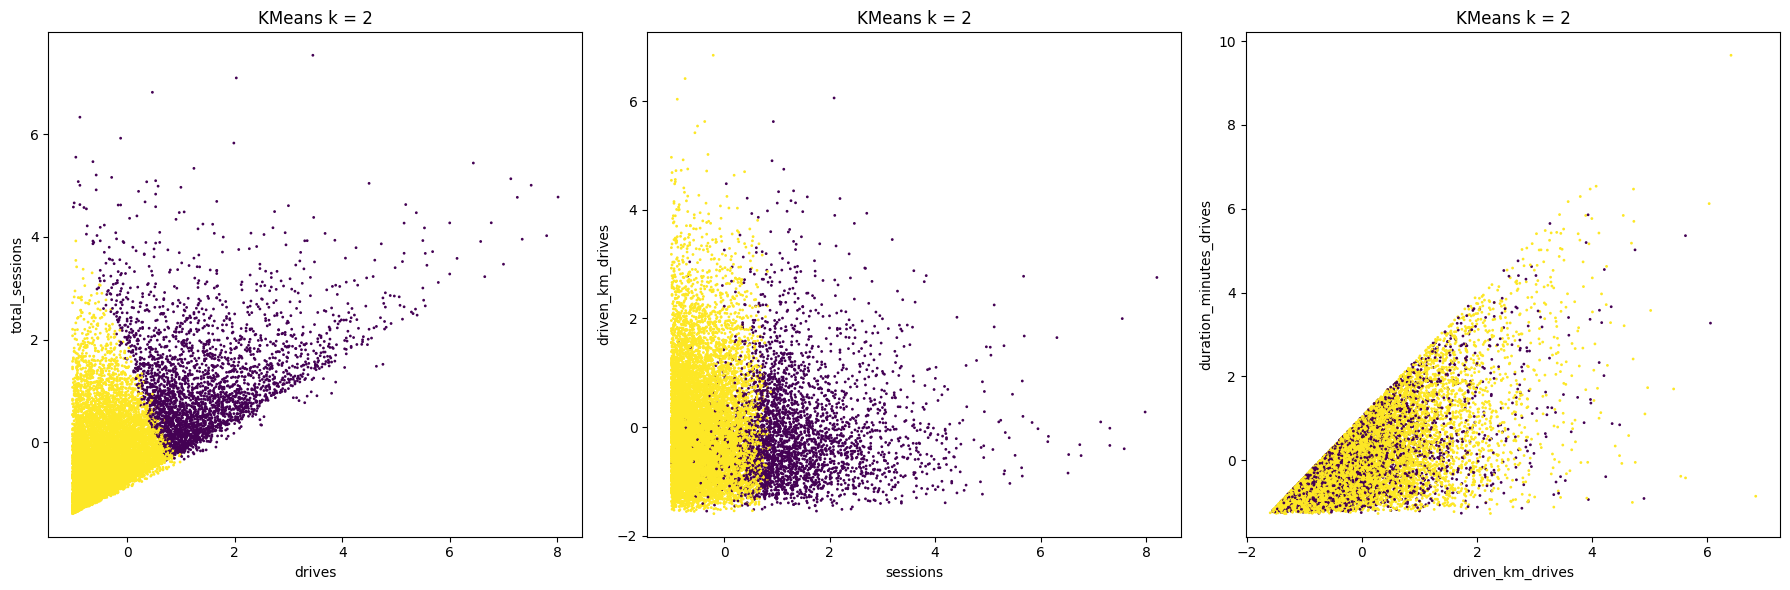

In [57]:
# 1. KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X.iloc[:, 1], X.iloc[:, 2], c=kmeans_labels, cmap='viridis', s=1)
plt.xlabel('drives')
plt.ylabel('total_sessions')
plt.title('KMeans k = 2')

plt.subplot(1, 3, 2)
plt.scatter(X.iloc[:, 0], X.iloc[:, 6], c=kmeans_labels, cmap='viridis', s=1)
plt.xlabel('sessions')
plt.ylabel('driven_km_drives')
plt.title('KMeans k = 2')

plt.subplot(1, 3, 3)
plt.scatter(X.iloc[:, 6], X.iloc[:, 7], c=kmeans_labels, cmap='viridis', s=1)
plt.xlabel('driven_km_drives')
plt.ylabel('duration_minutes_drives')
plt.title('KMeans k = 2')

plt.tight_layout()
plt.show()

DBSCAN Silhouette Score: -0.1176


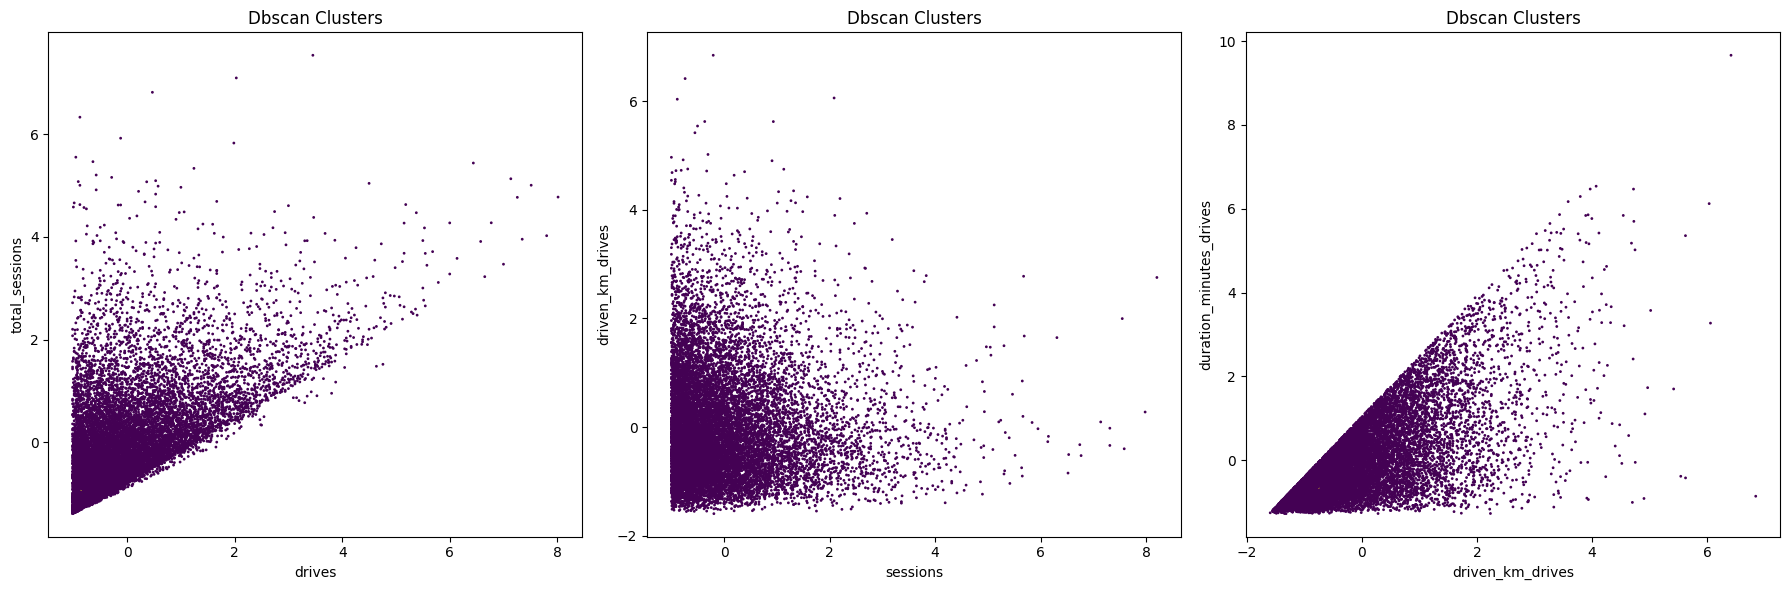

In [58]:
# 2. DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
dbscan_silhouette = silhouette_score(X, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.4f}")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X.iloc[:, 1], X.iloc[:, 2], c=dbscan_labels, cmap='viridis', s=1)
plt.xlabel('drives')
plt.ylabel('total_sessions')
plt.title('Dbscan Clusters')

plt.subplot(1, 3, 2)
plt.scatter(X.iloc[:, 0], X.iloc[:, 6], c=dbscan_labels, cmap='viridis', s=1)
plt.xlabel('sessions')
plt.ylabel('driven_km_drives')
plt.title('Dbscan Clusters')

plt.subplot(1, 3, 3)
plt.scatter(X.iloc[:, 6], X.iloc[:, 7], c=dbscan_labels, cmap='viridis', s=1)
plt.xlabel('driven_km_drives')
plt.ylabel('duration_minutes_drives')
plt.title('Dbscan Clusters')

plt.tight_layout()
plt.show()

Agglomerative Clustering Silhouette Score: 0.1400


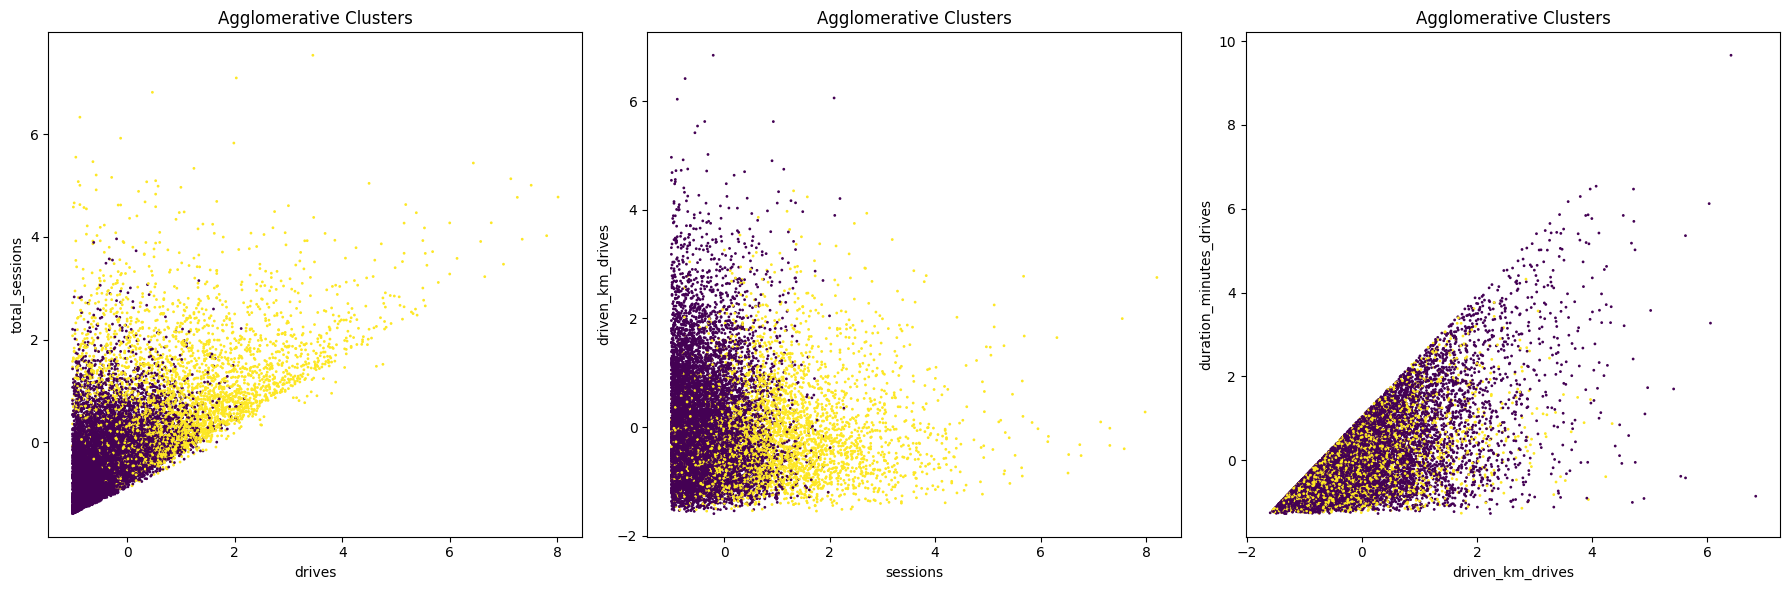

In [59]:
# 3. Agglomerative Clustering (Иерархическая кластеризация)
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X)
agglo_silhouette = silhouette_score(X, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette:.4f}")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(X.iloc[:, 1], X.iloc[:, 2], c=agglo_labels, cmap='viridis', s=1)
plt.xlabel('drives')
plt.ylabel('total_sessions')
plt.title('Agglomerative Clusters')

plt.subplot(1, 3, 2)
plt.scatter(X.iloc[:, 0], X.iloc[:, 6], c=agglo_labels, cmap='viridis', s=1)
plt.xlabel('sessions')
plt.ylabel('driven_km_drives')
plt.title('Agglomerative Clusters')

plt.subplot(1, 3, 3)
plt.scatter(X.iloc[:, 6], X.iloc[:, 7], c=agglo_labels, cmap='viridis', s=1)
plt.xlabel('driven_km_drives')
plt.ylabel('duration_minutes_drives')
plt.title('Agglomerative Clusters')

plt.tight_layout()
plt.show()

In [60]:
print(f"KMeans Silhouette Score: {kmeans_silhouette:.2f}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette:.2f}")
print("_____________________________________________________________________")
print(X)

KMeans Silhouette Score: 0.21
DBSCAN Silhouette Score: -0.11764402516497106
Agglomerative Clustering Silhouette Score: 0.14
_____________________________________________________________________
       sessions    drives  total_sessions  n_days_after_onboarding  \
0      2.506713  2.407221        0.787171                 0.519693   
1      0.648753  0.602687        1.008549                -0.522316   
2      0.413411  0.420717       -0.396699                 0.891485   
3     -0.391705 -0.413311       -0.895533                -1.721964   
4      0.041819  0.011285       -0.156408                -0.188199   
...         ...       ...             ...                      ...   
14994 -0.255455 -0.185849        0.134583                -1.598034   
14995 -0.478410 -0.489132       -0.013783                 0.746734   
14996  2.382849  2.301072        1.707015                 0.120141   
14997  0.846935  0.799821       -0.066257                 1.386216   
14998 -0.094432 -0.140357        1.2

**DBSCAN Silhouette Score: -0.1176**

Отрицательная оценка указывает на то, что объекты, которые вошли в кластер, на самом деле могут находиться ближе к объектам других кластеров. Это говорит о том, что кластеризация с использованием DBSCAN не удалась, и объекты распределены неравномерно или собраны в слишком больших или неправильных кластерах.

**KMeans Silhouette Score: 0.2121**

Положительное значение показывает, что KMeans смог выделить кластеры, которые имеют некоторую структуру. Хотя значение 0.2121 не является высоким, это все равно указывает на то, что объекты в кластерах отличаются друг от друга лучше, чем в DBSCAN. Это может свидетельствовать о том, что KMeans смог произвести более четкие группы по сравнению с DBSCAN.

**Agglomerative Clustering Silhouette Score: 0.1400**

Это значение также положительное, но ниже, чем у KMeans. Оно указывает на то, что агломеративная кластеризация смогла выделить некоторые кластеры, но уровень различия между кластерами не так хорош, как в случае с KMeans.

**Значение ARI**

KMeans ARI: 0.01

DBSCAN ARI: -0.00

Agglomerative Clustering ARI: 0.01

Все три значения близки к 0. Это указывают на то, что кластеризация выполнена не лучше случайного распределения кластеров. Это говорит о том, что алгоритмы не смогли выделить кластеры, которые соответствуют истинным меткам классов.

#Выводы
В данном случае плохая кластеризация всеми тремя методами связана с большой кучностью данных, которая не позволяет эффективно разбить данные на более чем 1 кластер, что видно на диаграммах рассеивания.

Лучший метод: При данной выборке объектов, на основании значений Silhouette Score, KMeans показывает наилучшие результаты среди трех методов.
